In [197]:
from typing import List, Tuple, TypeVar, Dict
import numpy as np
from tilsdk.localization import *

T = TypeVar('T')

def visualise_path(path, map):
    pathmap = map.grid.copy()
    pathmap = pathmap > 0
    pathmap = pathmap.astype("int32")
    gridpath = [map_.real_to_grid(x) if isinstance(x, RealLocation) else x for x in path]
    gridpathx = [x[0] for x in gridpath]
    gridpathy = [x[1] for x in gridpath]
    plt.imshow(pathmap)
    plt.scatter(gridpathx,gridpathy,c='r')
    plt.title("visualise grid and path")
    plt.show()


class MyPlanner:
    def __init__(self, map_:SignedDistanceGrid=None, waypoint_sparsity=0.5, optimize_threshold=3):
        '''
        Parameters
        ----------
        map : SignedDistanceGrid
            Distance grid map
        sdf_weight: float
            Relative weight of distance in cost function.
        waypoint_sparsity: float
            0.5 results in every 50th waypoint being taken at scale=0.01 and 10th at scale=0.05
        '''
        self.optimize_threshold = optimize_threshold
        self.map = map_
        self.bgrid = self.transform_add_border(map_.grid.copy()) #Grid which takes the borders into account
        self.astar_grid = self.transform_for_astar(self.bgrid.copy())
        self.waypoint_sparsity = waypoint_sparsity
        self.big_grid = [[0 for j in range(7)] for i in range(5)] #Big_grid stores whether each 1*1m tile of the arena has been visited
        self.big_grid_centre = [[0 for j in range(7)] for i in range(5)]
        for i in range(5):
            for j in range(7):
                self.big_grid_centre[i][j]=RealLocation(j+0.5,i+0.5)

    def transform_add_border(self, og_grid):
        grid = og_grid.copy()
        a,b = grid.shape
        for i in range(a):
            for j in range(b):
                grid[i][j] = min(grid[i][j],i+1,a-i,j+1,b-j)
        return grid

    def transform_for_astar(self, grid):
        #!-- Possible to edit this transform if u want
        grid2 = grid.copy()
        grid2[grid2>0] = 1 + 1000/(grid2[grid2>0])
        grid2[grid2<=0] = np.inf
        return grid2.astype("float32")

    @staticmethod
    def big_grid_of(l:RealLocation): #Returns the big grid array indices of a real location
        return int(l[0]//1),int(l[1]//1)
    
    def visit(self, l: RealLocation):
        indices = self.big_grid_of(l)
        self.big_grid[indices[0]][indices[1]] = max(1,self.big_grid[indices[0]][indices[1]])
        
    def get_explore(self, l:RealLocation): #Call this to get a location to go to if there are no locations of interest left
        m=100
        for i in range(5):
            for j in range(7):
                m=min(m,self.big_grid[i][j])
        if m == 1: #Can comment out this part if u want the robot to vroom around infinitely
            return None
        closest = (1e18,(-1,-1))
        for i in range(5):
            for j in range(7):
                if self.big_grid[i][j] == m:
                    closest = min(closest, (self.heuristic(self.big_grid_centre[i][j],l),(i,j)))
        self.big_grid[closest[1][0]][closest[1][1]] += 1
        return self.big_grid_centre[closest[1][0]][closest[1][1]]

    def heuristic(self, a:GridLocation, b:GridLocation) -> float:
        '''Planning heuristic function.        
        Parameters
        ----------
        a: GridLocation
            Starting location.
        b: GridLocation
            Goal location.
        '''
        return euclidean_distance(a, b)
    
    def nearest_clear(self, loc, passable):
        '''Utility function to find the nearest clear cell to a blocked cell'''
        if not passable[loc]:
            best = (1e18,(-1,-1))
            for i in range(map_.height): #y
                for j in range(map_.width): #x
                    if map_.grid[(i,j)]>0:
                        best = min(best,(self.heuristic(GridLocation(i,j),loc),(i,j)))
            loc = best[1]
        return loc

    def plan(self, start:RealLocation, goal:RealLocation) -> List[RealLocation]:
        '''Plan in real coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: RealLocation
            Starting location.
        goal: RealLocation
            Goal location.
        
        Returns
        -------
        path
            List of RealLocation from start to goal.
        '''

        path = self.plan_grid(self.map.real_to_grid(start), self.map.real_to_grid(goal))
        if path is None:
            return path
        visualise_path(path, self.map)
        path = [self.map.grid_to_real(wp) for wp in path]
        return path

    def plan_grid(self, start:GridLocation, goal:GridLocation) -> List[GridLocation]:
        '''Plan in grid coordinates.
        
        Raises NoPathFileException path is not found.

        Parameters
        ----------
        start: GridLocation
            Starting location.
        goal: GridLocation
            Goal location.
        
        Returns
        -------
        path
            List of GridLocation from start to goal.
        '''
        
        if not self.map:
            raise RuntimeError('Planner map is not initialized.')
        
        start = start[1],start[0]
        goal = goal[1],goal[0] #Use i=x,j=y convention for convenience
        passable = self.map.grid>0

        print("original start",start)
        print("original goal",goal)
        start = self.nearest_clear(start, passable)
        goal = self.nearest_clear(goal, passable)
        print("start",start)
        print("goal",goal)

        #astar
        path = pyastar2d.astar_path(self.astar_grid, start, goal, allow_diagonal=True)
        if path is None:
            return None
        coeff = int(self.waypoint_sparsity/self.map.scale) # default sparsity 0.5 --> 50 for 0.01, 10 for 0.05
        path = list(path)
        path = path[:1] + path[:-1:coeff] + path[-1:] #Take the 1st, last, and every 20th waypoint in the middle
        path.append(path[-1]) #Duplicate last waypoint to avoid bug in main loop
        path = [(x[1],x[0]) for x in path]
        return self.optimize_path(path)

    def optimize_path(self, path:List[GridLocation]) -> List[GridLocation]:
        new_path = [path[0]]  # starting point always in path
        for i in range(1, len(path)-1, 1):
            if not ((abs(path[i-1][0] - path[i][0]) < self.optimize_threshold and abs(path[i][0] - path[i+1][0]) < self.optimize_threshold) or (abs(path[i-1][1] - path[i][1]) < self.optimize_threshold and abs(path[i][1] - path[i+1][1]) < self.optimize_threshold)):  # 3 consecutive points are on a straight line in either x or y direction
                new_path.append(path[i])
        new_path.append(path[-1])  # add last point
        return new_path

In [198]:
import logging
from typing import List

from tilsdk import *                                            # import the SDK
from tilsdk.utilities import PIDController, SimpleMovingAverage # import optional useful things
from tilsdk.mock_robomaster.robot import Robot                  # Use this for the simulator
# from robomaster.robot import Robot                             # Use this for real robot

# Import your code
from stubs.cv_service import CVService, MockCVService
from stubs.nlp_service import NLPService, MockNLPService
from stubs.planner import Planner
import pyastar2d
import copy

In [199]:
# Setup logging in a nice readable format
logging.basicConfig(level=logging.INFO,
                format='[%(levelname)5s][%(asctime)s][%(name)s]: %(message)s',
                datefmt='%H:%M:%S')

# Define config variables in an easily accessible location
# You may consider using a config file
REACHED_THRESHOLD_M = 0.3   # TODO: Participant may tune.
ANGLE_THRESHOLD_DEG = 20.0  # TODO: Participant may tune.
ROBOT_RADIUS_M = 0.17       # TODO: Participant may tune.
NLP_MODEL_DIR = '../model.onnx'          # TODO: Participant to fill in.
NLP_PREPROCESSOR_DIR = '../finals_audio_model/'          # TODO: Participant to fill in.
CV_MODEL_DIR = ''           # TODO: Participant to fill in.

# Convenience function to update locations of interest.
def update_locations(old:List[RealLocation], new:List[RealLocation]) -> None:
    '''Update locations with no duplicates.'''
    if new:
        for loc in new:
            if loc not in old:
                logging.getLogger('update_locations').info('New location of interest: {}'.format(loc))
                old.append(loc)

In [200]:
# Initialize services
# cv_service = CVService(model_dir=CV_MODEL_DIR)

cv_service = MockCVService(model_dir=CV_MODEL_DIR)

#nlp_service = NLPService(model_dir=NLP_MODEL_DIR, preprocessor_dir=NLP_PREPROCESSOR_DIR)
nlp_service = MockNLPService(model_dir=NLP_MODEL_DIR)

loc_service = LocalizationService(host='localhost', port=5566)

#rep_service = ReportingService(host='localhost', port=5501)
# Start the run
#rep_service.start_run()

robot = Robot()
robot.initialize(conn_type="sta")
robot.camera.start_video_stream(display=False, resolution='720p')

In [254]:
# Initialize planner
map_:SignedDistanceGrid = loc_service.get_map()
map_ = map_.dilated(1.5*ROBOT_RADIUS_M/map_.scale)
planner = MyPlanner(map_, waypoint_sparsity=0.4, optimize_threshold=3)

# Initialize variables
seen_clues = set()
curr_loi:RealLocation = None
path:List[RealLocation] = []
lois:List[RealLocation] = []
curr_wp:RealLocation = None

# Initialize pose filter
pose_filter = SimpleMovingAverage(n=10)

# Define filter function to exclude clues seen before   
new_clues = lambda c: c.clue_id not in seen_clues

[WARNING][14:56:55][urllib3.connectionpool]: Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x00000263193329D0>: Failed to establish a new connection: [WinError 10061] 由于目标计算机积极拒绝，无法连接。')': /map


In [255]:
#Tune here
tracker = PIDController(Kp=(0.4, 0.5), Kd=(0.4, 0.5), Ki=(0.0, 0.0)) #first: displacement, second: angle

[ INFO][14:56:59][update_locations]: New location of interest: RealLocation(x=4.0, y=4.0)
[ INFO][14:56:59][Main]: Current LOI set to: RealLocation(x=4.0, y=4.0)
[ INFO][14:56:59][Main]: Planning path to: RealLocation(x=4.0, y=4.0)
[ INFO][14:56:59][Main]: No possible path found, location skipped
[ INFO][14:56:59][Main]: No more locations of interest.


original start (18, 11)
original goal (80, 80)
start (18, 11)
goal (80, 80)


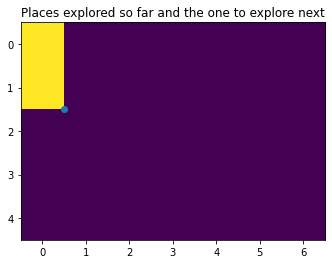

[ INFO][14:56:59][Main]: Current LOI set to: RealLocation(x=0.5, y=1.5)
[ INFO][14:56:59][Main]: Planning path to: RealLocation(x=0.5, y=1.5)


original start (19, 11)
original goal (30, 10)
start (19, 11)
goal (30, 10)


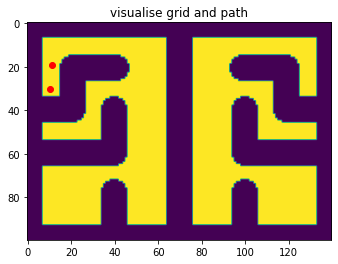

[ INFO][14:56:59][Main]: Path planned.
[ INFO][14:56:59][Navigation]: New waypoint: RealLocation(x=0.55, y=0.9500000000000001)
[ INFO][14:56:59][Navigation]: Reached wp: RealLocation(x=0.55, y=0.9500000000000001)
[ INFO][14:56:59][Navigation]: New waypoint: RealLocation(x=0.5, y=1.5)
[ INFO][14:56:59][Navigation]: End of path.
[ INFO][14:56:59][Main]: No more locations of interest.


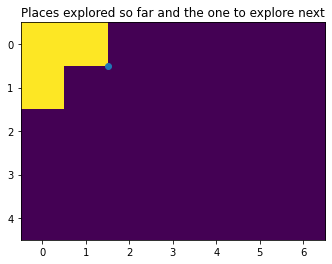

[ INFO][14:57:00][Main]: Current LOI set to: RealLocation(x=1.5, y=0.5)
[ INFO][14:57:00][Main]: Planning path to: RealLocation(x=1.5, y=0.5)


original start (20, 10)
original goal (10, 30)
start (20, 10)
goal (10, 30)


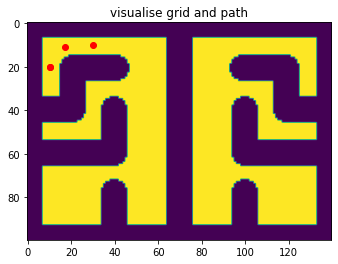

[ INFO][14:57:00][Main]: Path planned.
[ INFO][14:57:00][Navigation]: New waypoint: RealLocation(x=0.5, y=1.0)
[ INFO][14:57:00][Navigation]: Reached wp: RealLocation(x=0.5, y=1.0)
[ INFO][14:57:00][Navigation]: New waypoint: RealLocation(x=0.5, y=1.0)
[ INFO][14:57:00][Navigation]: Reached wp: RealLocation(x=0.5, y=1.0)
[ INFO][14:57:00][Navigation]: New waypoint: RealLocation(x=0.8500000000000001, y=0.55)
[ INFO][14:57:04][Navigation]: Reached wp: RealLocation(x=0.8500000000000001, y=0.55)
[ INFO][14:57:04][Navigation]: New waypoint: RealLocation(x=1.5, y=0.5)
[ INFO][14:57:04][Navigation]: End of path.
[ INFO][14:57:04][Main]: No more locations of interest.


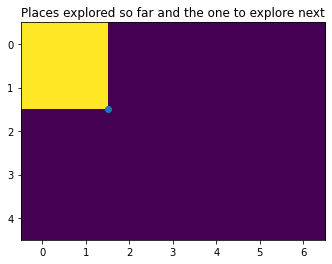

[ INFO][14:57:05][Main]: Current LOI set to: RealLocation(x=1.5, y=1.5)
[ INFO][14:57:05][Main]: Planning path to: RealLocation(x=1.5, y=1.5)


original start (16, 15)
original goal (30, 30)
start (16, 15)
goal (30, 30)


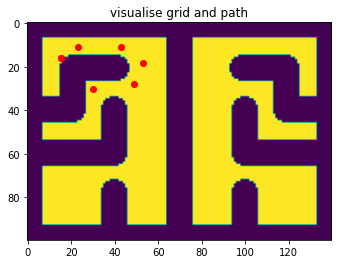

[ INFO][14:57:05][Main]: Path planned.
[ INFO][14:57:05][Navigation]: New waypoint: RealLocation(x=0.75, y=0.8)
[ INFO][14:57:05][Navigation]: Reached wp: RealLocation(x=0.75, y=0.8)
[ INFO][14:57:05][Navigation]: New waypoint: RealLocation(x=0.75, y=0.8)
[ INFO][14:57:05][Navigation]: Reached wp: RealLocation(x=0.75, y=0.8)
[ INFO][14:57:05][Navigation]: New waypoint: RealLocation(x=1.1500000000000001, y=0.55)
[ INFO][14:57:06][Navigation]: Reached wp: RealLocation(x=1.1500000000000001, y=0.55)
[ INFO][14:57:06][Navigation]: New waypoint: RealLocation(x=2.15, y=0.55)
[ INFO][14:57:11][Navigation]: Reached wp: RealLocation(x=2.15, y=0.55)
[ INFO][14:57:11][Navigation]: New waypoint: RealLocation(x=2.6500000000000004, y=0.9)
[ INFO][14:57:15][Navigation]: Reached wp: RealLocation(x=2.6500000000000004, y=0.9)
[ INFO][14:57:15][Navigation]: New waypoint: RealLocation(x=2.45, y=1.4000000000000001)
[ INFO][14:57:18][update_locations]: New location of interest: RealLocation(x=1.0, y=2.5)
[ I

original start (23, 50)
original goal (50, 20)
start (23, 50)
goal (50, 20)


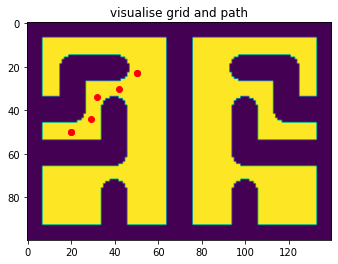

[ INFO][14:57:20][Main]: Path planned.
[ INFO][14:57:20][Navigation]: New waypoint: RealLocation(x=2.5, y=1.1500000000000001)
[ INFO][14:57:20][Navigation]: Reached wp: RealLocation(x=2.5, y=1.1500000000000001)
[ INFO][14:57:20][Navigation]: New waypoint: RealLocation(x=2.5, y=1.1500000000000001)
[ INFO][14:57:20][Navigation]: Reached wp: RealLocation(x=2.5, y=1.1500000000000001)
[ INFO][14:57:20][Navigation]: New waypoint: RealLocation(x=2.1, y=1.5)
[ INFO][14:57:24][Navigation]: Reached wp: RealLocation(x=2.1, y=1.5)
[ INFO][14:57:24][Navigation]: New waypoint: RealLocation(x=1.6, y=1.7000000000000002)


ProtocolError: ('Connection aborted.', ConnectionResetError(10054, '远程主机强迫关闭了一个现有的连接。', None, 10054, None))

In [256]:
# Main loop
while True:
    # Get new data
    pose, clues = loc_service.get_pose()
    pose = pose_filter.update(pose)
    img = robot.camera.read_cv2_image(strategy='newest')
    if not pose:
        # no new data, continue to next iteration.
        continue

    #Set this location as visited in the planner (so no need to visit here again if there are no clues)    
    planner.visit(pose[:2])
    
    # Filter out clues that were seen before
    clues = filter(new_clues, clues)

    # Process clues using NLP and determine any new locations of interest
    if clues:
        clues=list(clues) #It bugs without this
        new_lois = nlp_service.locations_from_clues(clues) #new locations of interest
        update_locations(lois, new_lois)
        seen_clues.update([c.clue_id for c in clues])

    """    # Process image and detect targets
    targets = cv_service.targets_from_image(img)

    # Submit targets
    if targets:
        logging.getLogger('Main').info('{} targets detected.'.format(len(targets)))
        #logging.getLogger('Reporting').info(rep_service.report(pose, img, targets))
    """
    if not curr_loi:
        if len(lois) == 0:
            logging.getLogger('Main').info('No more locations of interest.')
            explore_next = planner.get_explore(pose[:2])
            if type(explore_next) == type(None):
                break
            plt.imshow(planner.big_grid)
            plt.title("Places explored so far and the one to explore next")
            plt.scatter([explore_next[0]],[explore_next[1]])
            plt.show()
            lois.append(explore_next)
            #break
            
        # Get new LOI
        lois.sort(key=lambda l: euclidean_distance(l, pose), reverse=True)
        curr_loi = lois.pop()
        logging.getLogger('Main').info('Current LOI set to: {}'.format(curr_loi))

        # Plan a path to the new LOI
        logging.getLogger('Main').info('Planning path to: {}'.format(curr_loi))

        path = planner.plan(pose[:2], curr_loi)
        if type(path) == type(None):
            logging.getLogger('Main').info('No possible path found, location skipped')
            #print("lois",lois)
            #print("seen:",seen_clues)
            curr_loi = None
        else:
        #path = [curr_loi,curr_loi]
            path.reverse() # reverse so closest wp is last so that pop() is cheap , waypoint
            curr_wp = None
            logging.getLogger('Main').info('Path planned.')
    else:
        # There is a current LOI objective.
        # Continue with navigation along current path.
        if path:
            # Get next waypoint
            if not curr_wp:
                curr_wp = path.pop()
                logging.getLogger('Navigation').info('New waypoint: {}'.format(curr_wp))

            #logging.getLogger('Navigation').info('Calculating angle')
            # Calculate distance and heading to waypoint
            dist_to_wp = euclidean_distance(pose, curr_wp)
            ang_to_wp = np.degrees(np.arctan2(curr_wp[1]-pose[1], curr_wp[0]-pose[0]))
            ang_diff = -(ang_to_wp - pose[2]) # body frame

            # ensure ang_diff is in [-180, 180]
            if ang_diff < -180:
                ang_diff += 360

            if ang_diff > 180:
                ang_diff -= 360

            #logging.getLogger('Navigation').info('ang_to_wp: {}, hdg: {}, ang_diff: {}'.format(ang_to_wp, pose[2], ang_diff))
            #logging.getLogger('Navigation').info('Pose: {}'.format(pose))
            
            # Consider waypoint reached if within a threshold distance
            if dist_to_wp < REACHED_THRESHOLD_M:
                logging.getLogger('Navigation').info('Reached wp: {}'.format(curr_wp))
                tracker.reset()
                curr_wp = None
                continue

            # Determine velocity commands given distance and heading to waypoint
            vel_cmd = tracker.update((dist_to_wp, ang_diff))

            #logging.getLogger('Navigation').info('dist: {} ang:{} vel:{}'.format(dist_to_wp,ang_diff,vel_cmd))
            
            # reduce x velocity
            vel_cmd[0] *= np.cos(np.radians(ang_diff))

            # If robot is facing the wrong direction, turn to face waypoint first before
            # moving forward.
            if abs(ang_diff) > ANGLE_THRESHOLD_DEG:
                vel_cmd[0] = 0.0

            # Send command to robot
            robot.chassis.drive_speed(x=vel_cmd[0], z=vel_cmd[1])

        else:
            logging.getLogger('Navigation').info('End of path.')
            curr_loi = None

            # TODO: Perform search behaviour? Participant to complete.

            continue

robot.chassis.drive_speed(x=0.0, y=0.0, z=0.0)  # set stop for safety
logging.getLogger('Main').info('Mission Terminated.')

# Below: Random working

In [ ]:
planner.big_grid_centre

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,30))
ax[0].imshow(plt.imread("data/maps/map_complex_1cm.png"))
ax[0].title.set_text("Input map")
ax[1].imshow(map_.grid>0)
ax[1].title.set_text("map._grid>0 (indicates passable)")
ax[2].imshow(map_.grid)
ax[2].title.set_text("map._grid")

## Test planner manually

In [249]:
myplanner = MyPlanner(map_, waypoint_sparsity = 0.4, optimize_threshold=3)
curr_loi = RealLocation(x=3.0, y=4.0)
pose = RealPose(x=1.0, y=1.0, z=0.0)

original start (20, 20)
original goal (80, 60)
start (15, 18)
goal (80, 60)


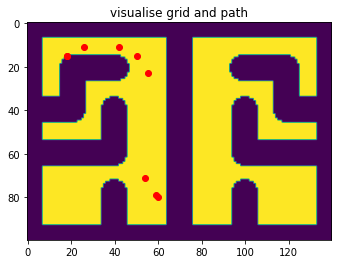

0.08207464218139648


In [250]:
import time
start = time.time()
path = None #Needed or path will be taken as a local variable in try
path = myplanner.plan(pose[:2], curr_loi)
end = time.time()
print(end - start)

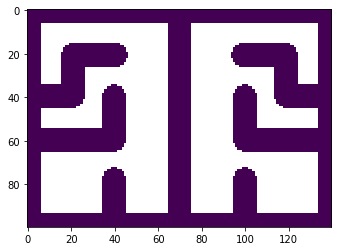

In [70]:
map = planner.map.grid.astype(np.float32)
map[map>0] = np.inf
map[map<=0] = 1
path_astar = pyastar2d.astar_path(map, tuple(real_to_grid(RealLocation(1, 1), scale=planner.map.scale)), tuple(real_to_grid(RealLocation(4, 3), scale=planner.map.scale)), allow_diagonal=True)
plt.imshow(map)
# path_astar.reverse()
# path_astar = path_astar[:1] + path_astar[1:-1:20]+ path_astar[-1:] #Take the 1st, last, and every 20th waypoint in the middle
# path_astar = [(x[1],x[0]) for x in path_astar]

original start (20, 80)
original goal (90, 80)
start (20, 80)
goal (90, 80)


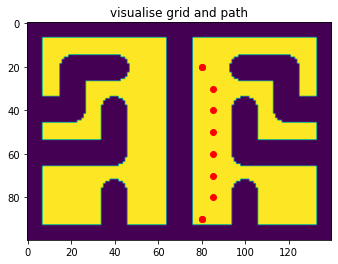

In [65]:
path = myplanner.plan(pose[:2], RealLocation(4.0,4.5), method="astar")

In [69]:
pose

RealPose(x=4.0, y=1.0, z=0.0)

In [66]:
myplanner.get_explore(pose[:2])

RealLocation(x=3.5, y=0.5)

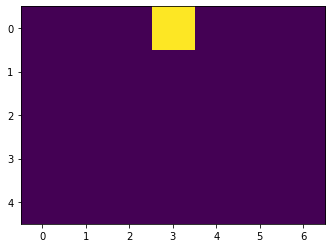

In [67]:
plt.imshow(myplanner.big_grid)

In [ ]:
big_grid_of(RealLocation(3.8,0.31))